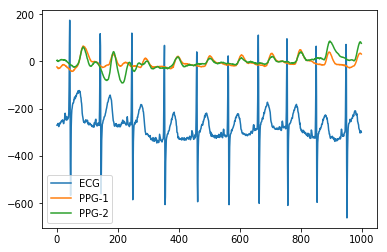

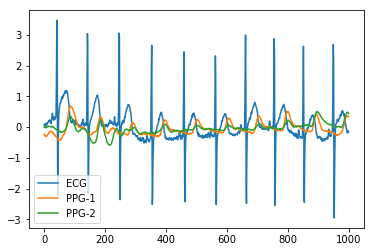

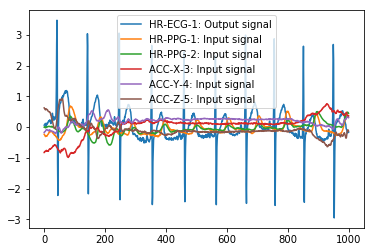

In [2]:
# Data: time-serie smartwatch or wristband or smartband data
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio

# Data reading
# # Linux-Ubuntu
# data_path = '/home/arasdar/data/Training_data/DATA_01_TYPE01.mat'
# Macbook
data_path = '/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat'
watch = spio.loadmat(data_path)
data = watch['sig']
data = np.array(data)
data.shape, watch['sig'].size/6

# Normalizing each batch of the data, each batch = each file
# Can we normalize them all at the same time?
mean = np.mean(data, axis=1)
std = np.std(data, axis=1)
var = np.var(data, axis=1)
std2 = np.sqrt(var)
mean.shape, var.shape, std.shape, std2.shape, std, std2, std-std2

mean = mean.reshape(-1, 1)
std = std.reshape(-1, 1)
mean.shape, std.shape
data_norm = (data - mean)/std
data.shape, data_norm.shape

# how to normalize, how to take mean, variance, and std
mean2 = np.mean(data, axis=1).reshape(-1, 1) # mean_nx1: n for dim and t for samples
var2 = data - mean2
var2 = np.square(var2)
var2 = np.mean(var2, axis=1)
std2 = np.sqrt(var2).reshape(-1, 1)
std2 - std

# The features/ channels of the data = ['HR-ECG', 'HR-PPG', 'ACC-X', 'ACC-Y', 'ACC-Z']
plt.plot(data[0, :1000], label='ECG')
plt.plot(data[1, :1000], label='PPG-1')
plt.plot(data[2, :1000], label='PPG-2')
# plt.plot(x_sig[3, :1000], label='ACC-X')
# plt.plot(x_sig[4, :1000], label='SCC-Y')
# plt.plot(x_sig[5, :1000], label='ACC-Z')
plt.legend()
plt.show()

# The features/ channels of the data = ['HR-ECG', 'HR-PPG', 'ACC-X', 'ACC-Y', 'ACC-Z']
plt.plot(data_norm[0, :1000], label='ECG')
plt.plot(data_norm[1, :1000], label='PPG-1')
plt.plot(data_norm[2, :1000], label='PPG-2')
# plt.plot(x_sig[3, :1000], label='ACC-X')
# plt.plot(x_sig[4, :1000], label='SCC-Y')
# plt.plot(x_sig[5, :1000], label='ACC-Z')
plt.legend()
plt.show()

# ECG
Y = data_norm[0]
X = data_norm[1:]
Y.shape, X.shape
Y = Y.reshape(1, -1)
Y.shape, X.shape
plt.plot(Y[0, :1000], label='HR-ECG-1: Output signal')
plt.plot(X[0, :1000], label='HR-PPG-1: Input signal')
plt.plot(X[1, :1000], label='HR-PPG-2: Input signal')
plt.plot(X[2, :1000], label='ACC-X-3: Input signal')
plt.plot(X[3, :1000], label='ACC-Y-4: Input signal')
plt.plot(X[4, :1000], label='ACC-Z-5: Input signal')
plt.legend()
plt.show()
X_train = X.T
Y_train = Y.T
X_train.shape, Y_train.shape

# Preparing the training data for seq2seq learning
Y_train_in = Y_train[:-2]
Y_train_out = Y_train[:-1]
#     Y_train_in.shape, Y_train.shape
firstrow = np.zeros([1, 1])
#     firstrow.shape, Y_train_in.shape
Y_train_in = np.row_stack((firstrow, Y_train_in))
#     Y_train_in.shape, Y_train_in[:5], Y_train[:5]
#     Y_train_out = Y_train.copy()
X_train.shape, Y_train_in.shape, Y_train_out.shape
XY_train = (X_train, Y_train)

# Read and normalize one batch/file of data
def read_data(data_path):
    band = spio.loadmat(data_path)
    data = band['sig']
    data = np.array(data)

    # Normalizing each batch of the data, each batch = each file
    # Can we normalize them all at the same time?
    mean = np.mean(data, axis=1).reshape(-1, 1)
    std = np.std(data, axis=1).reshape(-1, 1)
    data_norm = (data - mean)/std
    
    # Input-XX and Output-Y signals
    # Y: ECG, X: PPG: HR 2 signals + ACC: XYZ
    Y = data_norm[0]
    X = data_norm[1:]
    Y = Y.reshape(1, -1)    
    X_train = X.T
    Y_train = Y.T
    return X_train, Y_train

In [3]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:

    def __init__(self, D, C, H, L):
        self.D = D # number of input dimensions
        self.H = H # number of hidden units
        self.L = L # number of hidden layers
        self.C = C # number of output classes/dimensions
        self.losses = {'train':[]} # , 'valid:[]', 'test':[]
        
        # Seq 1: input seq
        Z = H + D
        m_in = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(D / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        
        # Seq 1 last layer
        m_in_last_layer = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H))
        )
        
        # Seq 2: output seq
        Z = H + C
        m_out = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, C) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, C))
        )

        # Model parameters
        self.model = []
        num_modes = 2 # num of modality/sequences
        for _ in range(num_modes):
            self.model.append([])
        
        for _ in range(self.L-1):
            self.model[0].append(m_in)

        # The last layer: self.L-1
        self.model[0].append(m_in_last_layer)
        
        # Number of layers for each mode
        for _ in range(self.L):
            self.model[1].append(m_out)
            
    def initial_state(self):
        return np.zeros((1, self.H))
    
    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def forward_(self, X, h, m):
        Wz, Wr, Wh = m['Wz'], m['Wr'], m['Wh']
        bz, br, bh = m['bz'], m['br'], m['bh']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache)

        return h, cache

    def backward_(self, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache = cache
        
        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, bz=dbz, br=dbr, bh=dbh)
        
        return dX, dh, grad
    
    def train_forward(self, XY_train, h):
        # Adding the output layer cache
        caches = []
        num_modes = 2
        for _ in range(num_modes):
            caches.append([])
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches[0].append([])
            caches[1].append([])
            
        ys = []
        X_train, Y_train = XY_train
        
        # Input sequence or Seq 1
        for X in X_train: # X_txn, 
            X= X.reshape(1, -1) # x_1xn
            
            for layer in range(0, self.L - 1, 1):
                y, h[layer], cache = self.forward(X, h[layer], self.model[0][layer])
                caches[0][layer].append(cache)
                X = y.copy()
            
            for layer in range(self.L - 1, self.L, 1):
                h[layer], cache = self.forward_(X, h[layer], self.model[0][layer])
                caches[0][layer].append(cache)
            
        # Output sequence or seq 2
        for X in Y_train: # Y_txn
            X= X.reshape(1, -1) # X_1xn
            
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[1][layer])
                caches[1][layer].append(cache)
                X = y.copy()

            # Output list
            ys.append(y)
            
        return ys, caches

    def loss_function(self, y_pred, y_train):
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train):
            loss += l2_regression(y_pred=y, y_train=Y) #/ m: t or number of samples for taking the average
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        num_modes = 2
        for _ in range(num_modes):
            grad.append([])
            grads.append([])
        
        for _ in range(self.L):
            dh.append(np.zeros((1, self.H)))
            
        for mode in range(num_modes):
            for layer in range(self.L):
                grad[mode].append({key: np.zeros_like(val) for key, val in self.model[mode][layer].items()})
                grads[mode].append({key: np.zeros_like(val) for key, val in self.model[mode][layer].items()})

        # Output sequence = seq 2 = ECG
        dXs_2 = []
        for t in reversed(range(len(dys))):
            dy = dys[t].copy()
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[1][layer] = self.backward(dy, dh[layer], caches[1][layer][t])
                for key in grad[1][layer].keys():
                    grads[1][layer][key] += grad[1][layer][key]
                dy = dX.copy()
            dXs_2.append(dX)

        # Input sequence = seq 1 = PPG & ACC: mode == 0
        dXs_1 = []
        for t in reversed(range(len(dys))):
            # The depth and number of layers for RNN
            for layer in reversed(range(self.L-1, self.L, 1)):
                dX, dh[layer], grad[0][layer] = self.backward_(dh[layer], caches[0][layer][t])
                for k in grad[0][layer].keys():
                    grads[0][layer][k] += grad[0][layer][k]
                dy = dX.copy()
                
            # The depth and number of layers for RNN
            for layer in reversed(range(0, self.L-1, 1)):
                dX, dh[layer], grad[0][layer] = self.backward(dy, dh[layer], caches[0][layer][t])
                for k in grad[0][layer].keys():
                    grads[0][layer][k] += grad[0][layer][k]
                dy = dX.copy()
            dXs_1.append(dX)
            
        dXs = (dXs_1, dXs_2)
        
        return dXs, grads
    
    # Test/predict is only the forward pass/prop
    # def train_forward(self, XY_train, h):
    def test(self, Xs, h):

        # Initializing the hidden states == h
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        # Input sequence OR Seq 1 or Xs
        for X in Xs: # X_txn, 
            X= X.reshape(1, -1) # x_1xn
            
            for layer in range(0, self.L - 1, 1):
                y, h[layer], _ = self.forward(X, h[layer], self.model[0][layer])
                X = y.copy()
            
            # The last layer without y; The output is h
            for layer in range(self.L - 1, self.L, 1):
                h[layer], _ = self.forward_(X, h[layer], self.model[0][layer])
                
        # Output sequence OR seq 2 OR ys
        X = np.zeros((1, self.C)) # X_txn, t: num_sam, n: num_dim
        ys = []

        # for t in range(0, X_seq1.shape[0], 1): # Y_txn
        for _ in range(Xs.shape[0]): # X_txn
            X= X.reshape(1, -1) # X_1xn

            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[1][layer])
                X = y.copy()

            # Output list
            ys.append(y)
        
        return ys

In [3]:
def get_minibatch(X, Y, minibatch_size): # shuffle: this is for static data not dynamic/sequential data
    minibatches = []
    
    # for i in range(start=0, stop=X.shape[0], step=minibatch_size):
    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        Y_mini = Y[i:i + minibatch_size]
        minibatches.append((X_mini, Y_mini))

    return minibatches

def adam_rnn(nn, alpha, mb_size, n_iter, print_after, n_files):
    M, R = [], []
    num_modes = 2
    for _ in range(num_modes):
        M.append([])
        R.append([])

    for mode in range(num_modes):
        for layer in range(nn.L):
            M[mode].append({k: np.zeros_like(v) for k, v in nn.model[mode][layer].items()})
            R[mode].append({k: np.zeros_like(v) for k, v in nn.model[mode][layer].items()})

    beta1 = .9
    beta2 = .99
    state = nn.initial_state()
    eps = 1e-8 # constant
    
    # Epochs
    for iter in range(1, n_iter + 1):
        
        total_loss = 0
        
        # Read the new file, normalize it, and separate it into input and target
        for file_num in range(1, n_files + 1):
            
            if file_num == 1: data_path = '/Users/arasdar/data/Training_data/DATA_{:02}_TYPE01.mat'.format(file_num)
            else: data_path = '/Users/arasdar/data/Training_data/DATA_{:02}_TYPE02.mat'.format(file_num)
#             if file_num == 1: data_path = '/home/arasdar/data/Training_data/DATA_{:02}_TYPE01.mat'.format(file_num)
#             else: data_path = '/home/arasdar/data/Training_data/DATA_{:02}_TYPE02.mat'.format(file_num)
            print(data_path)

            # Read the mat files, normalize each batch of them, and seperate the output and input
            X_train, Y_train = read_data(data_path=data_path)
            #             X_train, Y_train_in = XY_train
            #             print(X_train.shape, Y_train_in.shape, Y_train_out.shape)

            # Minibatches/ Stochasticity
            #             minibatches = get_minibatch(X_train, Y_train, mb_size, shuffle=False)
            minibatches = get_minibatch(X=X_train, Y=Y_train, minibatch_size=mb_size) #, shuffle=False
            #             print('The number of minibatches in a sequence for each epoch iteration: {}'.format (len(minibatches)))

            # Minibatches/ Stochasticity
            #             print('The number of minibatches in a sequence for each epoch iteration: {}'.format (len(minibatches)))
            for idx in range(len(minibatches)):
                
                # Gradients
                X_mini, Y_mini = minibatches[idx]
                Y_mini_out = Y_mini[:-1] # mat[t, n]== Y_txn
                Y_mini_in = Y_mini[:-2]
                firstrow = np.zeros((1, Y_mini.shape[1])) # Y_mini.shape[0] == t, Y_mini.shape[1] == n
                Y_mini_in = np.row_stack((firstrow, Y_mini_in)) # shift foward by one

                XY_mini = (X_mini, Y_mini_in)
                ys, caches = nn.train_forward(XY_mini, state)
                loss, dys = nn.loss_function(y_train=Y_mini_out, y_pred=ys)
                _, grads = nn.train_backward(dys, caches)
                
                # MiniBatches: Drawing the learning curve for loss (Error/loss curve)
                nn.losses['train'].append(loss)
                
                # Descend
                for mode in range(num_modes):
                    for layer in range(nn.L):
                        for key in grads[mode][layer].keys(): #key, value: items
                            M[mode][layer][key] = l.exp_running_avg(M[mode][layer][key], grads[mode][layer][key], beta1)
                            R[mode][layer][key] = l.exp_running_avg(R[mode][layer][key], grads[mode][layer][key]**2, beta2)

                            m_k_hat = M[mode][layer][key] / (1. - (beta1**(iter)))
                            r_k_hat = R[mode][layer][key] / (1. - (beta2**(iter)))

                            nn.model[mode][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            # Total loss for every batchfile/batch by accumulating them one by one
            total_loss += loss

                            
        # Print training loss
        if iter % print_after == 0:
            # print('Iter-{} training loss: {:.4f}'.format(iter, loss))
            print('Iter-{} training loss: {:.4f}'.format(iter, total_loss))
            total_loss = 0
            #             mb_num = len(minibatches)//2 # the middle one
            #             X_mini, Y_mini = minibatches[mb_num] 
            #             ys = nn.test(X_mini, state)
            #             loss, _ = nn.loss_function(y_train=Y_mini, y_pred=ys)
            #             print('Iter-{} testing loss: {:.4f}'.format(iter, loss))
                            
    return nn

/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-1 training loss: 55.9275
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/d

/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-13 training loss: 54.1463
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/

/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-25 training loss: 58.6472
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-26 training loss: 57.7636
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DAT

Iter-37 training loss: 46.2561
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-38 training loss: 45.9052
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DAT

/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-50 training loss: 45.1594
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/

/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-62 training loss: 38.7051
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-63 training loss: 38.6483
/Users/arasdar/data/Training_data/DAT

/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-74 training loss: 34.7866
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-75 training loss: 34.8010
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DAT

/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-87 training loss: 32.5297
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/

/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-99 training loss: 31.8822
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-100 traini

/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-111 training loss: 27.5635
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-112 training loss: 29.0927
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/D

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-124 training loss: 24.3937
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar

/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-136 training loss: 22.8065
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar

/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-148 training loss: 26.5862
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-149 training loss: 25.2055
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/D

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-161 training loss: 23.7695
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar

/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-173 training loss: 25.6839
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar

/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-185 training loss: 23.4263
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-186 training loss: 22.6883
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/D

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_08_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_09_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_10_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_11_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_12_TYPE02.mat
Iter-198 training loss: 18.9964
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
/Users/arasdar

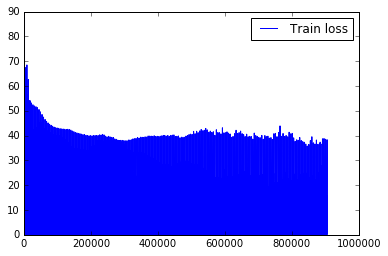

In [4]:
# hyper parameters
n_iter = 200 # epochs: processing speed and how much time it takes.
n_files = 12 # dataset size: maximum number of files in dataset based on 12 subjects
print_after = 1 # print loss of train, valid, and test
time_step = 100 # width of the model or minibatch size
alpha = 1e-4 # 0.001 - This is set to 1/miniatch_size (mb_size) or num_time_steps
num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
num_hidden_layers = 2 # depth or number of hidden layer
num_input_units = X_train.shape[1] # number of input features/dimensions
num_output_units = Y_train.shape[1]
# X_train.shape, Y_train.shape

net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

adam_rnn(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, n_files=n_files, print_after=print_after)

# Display the learning curve and losses for training, validation, and testing
# % matplotlib inline
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.legend()
plt.show()

/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-1 training loss: 3.2736
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-2 training loss: 3.2652
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04

/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-21 training loss: 1.9356
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-22 training loss: 1.8656
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-23 training loss: 1.8071
/Users/ar

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-42 training loss: 1.0001
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-43 training loss: 0.9814
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_

/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-62 training loss: 1.3740
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-63 training loss: 1.3578
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-64 training loss: 1.3356
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/ar

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-83 training loss: 0.7971
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_07_TYPE02.mat
Iter-84 training loss: 0.7934
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_

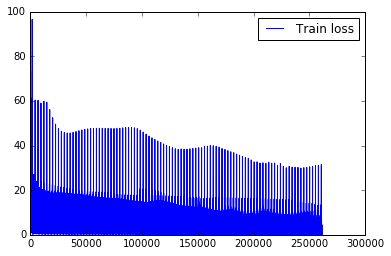

In [4]:
# # hyper parameters
# n_iter = 100 # epochs: processing speed and how much time it takes.
# n_files = 7 # dataset size: maximum number of files in dataset based on 12 subjects
# print_after = 1 # print loss of train, valid, and test
# time_step = 100 # width of the model or minibatch size
# alpha = 1e-4 # 0.001 - This is set to 1/miniatch_size (mb_size) or num_time_steps
# num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
# num_hidden_layers = 2 # depth or number of hidden layer
# num_input_units = X_train.shape[1] # number of input features/dimensions
# num_output_units = Y_train.shape[1]
# # X_train.shape, Y_train.shape

# net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

# adam_rnn(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, n_files=n_files, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# # % matplotlib inline
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.legend()
# plt.show()

/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-1 training loss: 5.3307
Iter-1 testing loss: 87.3933
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-2 training loss: 4.8822
Iter-2 testing loss: 74.9274
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DA

/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-22 training loss: 4.8865
Iter-22 testing loss: 98.4322
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-23 training loss: 4.9602
Iter-23 testing loss: 53.7473
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-24 training loss: 5.0389
Iter-24 testing loss: 55.6707
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Train

/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-44 training loss: 4.5702
Iter-44 testing loss: 38.5812
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-45 training loss: 4.3602
Iter-45 testing loss: 32.1605
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-46 training loss: 4.1509
Iter-46 testing loss: 34.2401
/Users/arasdar/data/Train

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-66 training loss: 1.0112
Iter-66 testing loss: 32.6833
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-67 training loss: 0.8308
Iter-67 testing loss: 40.8817
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_dat

Iter-87 training loss: 0.6133
Iter-87 testing loss: 54.8682
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-88 training loss: 0.5232
Iter-88 testing loss: 61.3683
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-89 training loss: 0.4906
Iter-89 testing loss: 59.3029
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Train

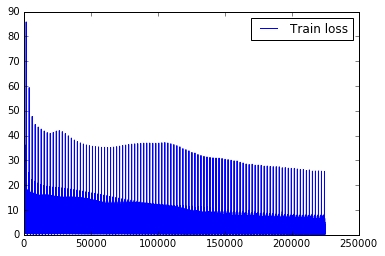

In [43]:
# # hyper parameters
# n_iter = 100 # epochs: processing speed and how much time it takes.
# n_files = 6 # dataset size: maximum number of files in dataset based on 12 subjects
# print_after = 1 # print loss of train, valid, and test
# time_step = 100 # width of the model or minibatch size
# alpha = 1e-4 # 0.001 - This is set to 1/miniatch_size (mb_size) or num_time_steps
# num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
# num_hidden_layers = 2 # depth or number of hidden layer
# num_input_units = X_train.shape[1] # number of input features/dimensions
# num_output_units = Y_train.shape[1]
# # X_train.shape, Y_train.shape

# net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

# adam_rnn(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, n_files=n_files, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# # % matplotlib inline
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.legend()
# plt.show()

/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-1 training loss: 5.7932
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-2 training loss: 4.9003
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06

/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-24 training loss: 4.4190
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-25 training loss: 4.3608
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-26 training loss: 4.2903
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/ar

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-48 training loss: 3.2052
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-49 training loss: 3.1834
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-50 training loss: 3.1570
/Users/ar

/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-71 training loss: 2.9487
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-72 training loss: 2.8822
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-73 training loss: 2.7162
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/ar

/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-95 training loss: 3.0164
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-96 training loss: 3.0114
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_06_TYPE02.mat
Iter-97 training loss: 2.8309
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/ar

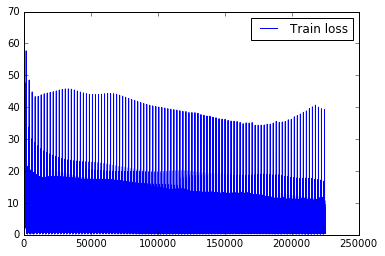

In [4]:
# # hyper parameters
# n_iter = 100 # epochs: processing speed and how much time it takes.
# n_files = 6 # dataset size: maximum number of files in dataset based on 12 subjects
# print_after = 1 # print loss of train, valid, and test
# time_step = 100 # width of the model or minibatch size
# alpha = 1e-4 # 0.001 - This is set to 1/miniatch_size (mb_size) or num_time_steps
# num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
# num_hidden_layers = 1 # depth or number of hidden layer
# num_input_units = X_train.shape[1] # number of input features/dimensions
# num_output_units = Y_train.shape[1]
# # X_train.shape, Y_train.shape

# net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

# adam_rnn(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, n_files=n_files, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# # % matplotlib inline
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.legend()
# plt.show()

/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-1 training loss: 2.9705
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-2 training loss: 2.2583
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-3 training loss: 1.9912
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasd

Iter-28 training loss: 1.4307
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-29 training loss: 1.4285
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-30 training loss: 1.4246
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-31 training loss: 1.4177
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_dat

/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-56 training loss: 1.1404
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-57 training loss: 1.1300
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-58 training loss: 1.1203
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-59 training loss: 1.1122
/Users/arasdar/data/Training_dat

/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-84 training loss: 1.1824
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-85 training loss: 1.1808
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-86 training loss: 1.1756
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_05_TYPE02.mat
Iter-87 t

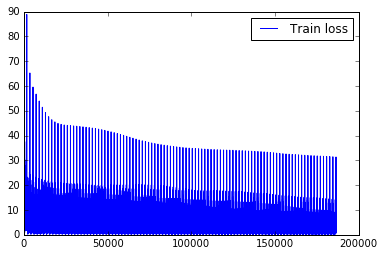

In [5]:
# # hyper parameters
# n_iter = 100 # epochs: processing speed and how much time it takes.
# n_files = 5 # dataset size: maximum number of files in dataset based on 12 subjects
# print_after = 1 # print loss of train, valid, and test
# time_step = 100 # width of the model or minibatch size
# alpha = 1e-4 # 0.001 - This is set to 1/miniatch_size (mb_size) or num_time_steps
# num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
# num_hidden_layers = 1 # depth or number of hidden layer
# num_input_units = X_train.shape[1] # number of input features/dimensions
# num_output_units = Y_train.shape[1]
# # X_train.shape, Y_train.shape

# net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

# adam_rnn(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, n_files=n_files, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# # % matplotlib inline
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.legend()
# plt.show()

/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-1 training loss: 3.0640
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-2 training loss: 1.3098
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-3 training loss: 0.9533
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-4 training loss: 0.8257
/Users/arasdar/data/Training_data/DA

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-35 training loss: 0.4761
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-36 training loss: 0.4713
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-37 training loss: 0.4668
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-38 training loss: 0.4631
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_dat

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-69 training loss: 0.5877
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-70 training loss: 0.6026
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-71 training loss: 0.6027
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_04_TYPE02.mat
Iter-72 training loss: 0.6056
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_dat

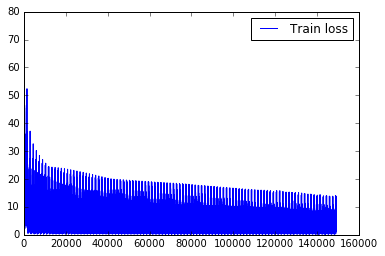

In [27]:
# # hyper parameters
# n_iter = 100 # epochs: processing speed and how much time it takes.
# n_files = 4 # dataset size: maximum number of files in dataset based on 12 subjects
# print_after = 1 # print loss of train, valid, and test
# time_step = 100 # width of the model or minibatch size
# alpha = 1e-4 # 0.001 - This is set to 1/miniatch_size (mb_size) or num_time_steps
# num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
# num_hidden_layers = 1 # depth or number of hidden layer
# num_input_units = X_train.shape[1] # number of input features/dimensions
# num_output_units = Y_train.shape[1]
# # X_train.shape, Y_train.shape

# net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

# adam_rnn(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, n_files=n_files, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# # % matplotlib inline
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.legend()
# plt.show()

/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-1 training loss: 6.7396
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-2 training loss: 2.3228
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-3 training loss: 1.8399
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-4 training loss: 1.7443
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-5 training loss: 1.6975
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/

/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-44 training loss: 1.0073
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-45 training loss: 0.9929
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-46 training loss: 0.9788
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-47 training loss: 0.9650
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-48 training loss: 0.9514
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
It

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-88 training loss: 0.7808
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-89 training loss: 0.7593
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-90 training loss: 0.7581
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-91 training loss: 0.7311
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/Users/arasdar/data/Training_data/DATA_03_TYPE02.mat
Iter-92 training loss: 0.6543
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
/U

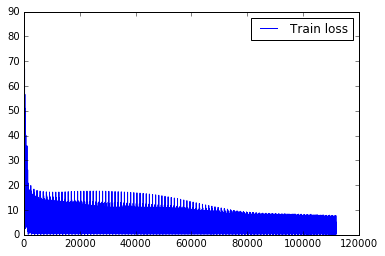

In [26]:
# # hyper parameters
# n_iter = 100 # epochs: processing speed and how much time it takes.
# n_files = 3 # dataset size: maximum number of files in dataset based on 12 subjects
# print_after = 1 # print loss of train, valid, and test
# time_step = 100 # width of the model or minibatch size
# alpha = 1e-4 # 0.001 - This is set to 1/miniatch_size (mb_size) or num_time_steps
# num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
# num_hidden_layers = 1 # depth or number of hidden layer
# num_input_units = X_train.shape[1] # number of input features/dimensions
# num_output_units = Y_train.shape[1]
# # X_train.shape, Y_train.shape

# net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

# adam_rnn(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, n_files=n_files, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# # % matplotlib inline
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.legend()
# plt.show()

/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-1 training loss: 10.8140
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-2 training loss: 10.5160
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-3 training loss: 10.2500
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-4 training loss: 10.1040
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-5 training loss: 9.9796
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-6 training loss: 9.8500
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-7 training loss: 9.7225
/Users/arasdar/data/Training_data/DATA_01_TYPE01.ma

/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-61 training loss: 4.7269
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-62 training loss: 4.5818
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-63 training loss: 4.4423
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-64 training loss: 4.3087
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-65 training loss: 4.1805
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-66 training loss: 4.0552
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02.mat
Iter-67 training loss: 3.9291
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
/Users/arasdar/data/Training_data/DATA_02_TYPE02

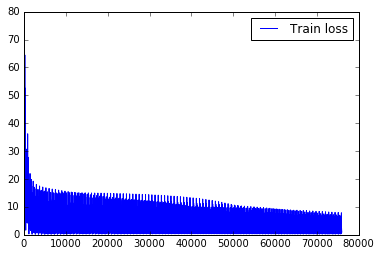

In [22]:
# # hyper parameters
# n_iter = 100 # epochs: processing speed and how much time it takes.
# n_files = 2 # dataset size: maximum number of files in dataset based on 12 subjects
# print_after = 1 # print loss of train, valid, and test
# time_step = 100 # width of the model or minibatch size
# alpha = 1e-4 # 0.001 - This is set to 1/miniatch_size (mb_size) or num_time_steps
# num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
# num_hidden_layers = 1 # depth or number of hidden layer
# num_input_units = X_train.shape[1] # number of input features/dimensions
# num_output_units = Y_train.shape[1]
# # X_train.shape, Y_train.shape

# net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

# adam_rnn(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, n_files=n_files, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# # % matplotlib inline
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.legend()
# plt.show()

/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-1 training loss: 7.3380
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-2 training loss: 3.5217
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-3 training loss: 1.7416
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-4 training loss: 1.0132
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-5 training loss: 0.7681
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-6 training loss: 0.6669
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-7 training loss: 0.6093
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-8 training loss: 0.5717
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-9 training loss: 0.5470
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-10 training loss: 0.5315
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-11 training loss: 0.5225
/Users/arasdar/data/Training_data/DATA_01_TYPE01.mat
Iter-12 training loss: 0.5180
/Users/arasda

Iter-100 training loss: 0.9249


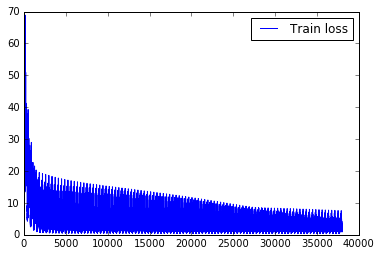

In [21]:
# # hyper parameters
# n_iter = 100 # epochs: processing speed and how much time it takes.
# n_files = 1 # dataset size: maximum number of files in dataset based on 12 subjects
# print_after = 1 # print loss of train, valid, and test
# time_step = 100 # width of the model or minibatch size
# alpha = 1e-4 # 0.001 - This is set to 1/miniatch_size (mb_size) or num_time_steps
# num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
# num_hidden_layers = 1 # depth or number of hidden layer
# num_input_units = X_train.shape[1] # number of input features/dimensions
# num_output_units = Y_train.shape[1]
# # X_train.shape, Y_train.shape

# net = GRU(D=num_input_units, H=num_hidden_units, L=num_hidden_layers, C=num_output_units)

# adam_rnn(nn=net, alpha=alpha, mb_size=time_step, n_iter=n_iter, n_files=n_files, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# # % matplotlib inline
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.legend()
# plt.show()